## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

results = {}

In [8]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt_best = ModelCheckpoint(filepath="./output/Day_086_best.h5", 
                                  monitor="val_loss", 
                                  save_best_only=True)
model_ckpt_weight = ModelCheckpoint(filepath="./output/Day_086_weights.h5", 
                                  monitor="val_loss", 
                                  save_weights_only=True)

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

# Best Only
model1 = build_mlp(input_shape=x_train.shape[1:])
model1.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model1.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt_best],
          use_multiprocessing=False
         )

# Collect results
train_loss = model1.history.history["loss"]
valid_loss = model1.history.history["val_loss"]
train_acc = model1.history.history["accuracy"]
valid_acc = model1.history.history["val_accuracy"]

# Load back
model1b = keras.models.load_model("./output/Day_086_best.h5")
loss_loadback, acc_loadback = model1b.evaluate(x_test, y_test)


results["best_only"] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc,
                         'loss_loadback': loss_loadback,
                         'acc_loadback': acc_loadback}

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512 

50000/50000 [==============================] - 6s 121us/step - loss: 0.5655 - accuracy: 0.8319 - val_loss: 1.6238 - val_accuracy: 0.4910
Epoch 47/50
50000/50000 [==============================] - 6s 122us/step - loss: 0.5476 - accuracy: 0.8393 - val_loss: 1.6657 - val_accuracy: 0.4886
Epoch 48/50
50000/50000 [==============================] - 6s 121us/step - loss: 0.5320 - accuracy: 0.8444 - val_loss: 1.6574 - val_accuracy: 0.4916
Epoch 49/50
50000/50000 [==============================] - 6s 121us/step - loss: 0.5172 - accuracy: 0.8501 - val_loss: 1.6729 - val_accuracy: 0.4822
Epoch 50/50
10000/10000 [==============================] - 2s 175us/step


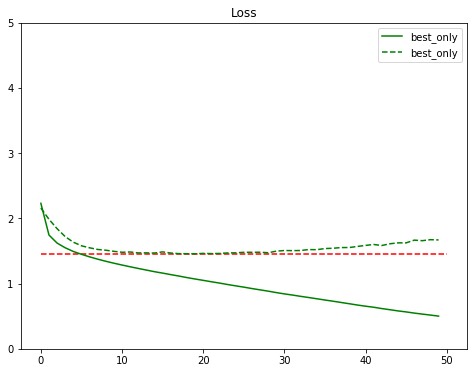

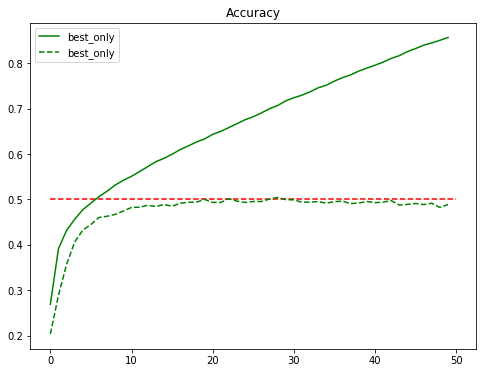

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["g", "b", "c", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['loss_loadback'], xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['acc_loadback'], xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt_weight = ModelCheckpoint(filepath="./output/Day_086_weights.h5", 
                                  monitor="val_loss", 
                                  save_weights_only=True)

# Weight Only
model2 = build_mlp(input_shape=x_train.shape[1:])
model2.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model2.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt_weight],
          use_multiprocessing=False
         )

# Collect results
train_loss = model2.history.history["loss"]
valid_loss = model2.history.history["val_loss"]
train_acc = model2.history.history["accuracy"]
valid_acc = model2.history.history["val_accuracy"]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 7s 131us/step - loss: 0.5550 - accuracy: 0.8380 - val_loss: 1.6421 - val_accuracy: 0.4870
Epoch 47/50
50000/50000 [==============================] - 6s 130us/step - loss: 0.5381 - accuracy: 0.8460 - val_loss: 1.6346 - val_accuracy: 0.4901
Epoch 48/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.5215 - accuracy: 0.8506 - val_loss: 1.6484 - val_accuracy: 0.4882
Epoch 49/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.5051 - accuracy: 0.8581 - val_loss: 1.6733 - val_accuracy: 0.4899
Epoch 50/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.4888 - accuracy: 0.8649 - val_loss: 1.6865 - val_accuracy: 0.4866


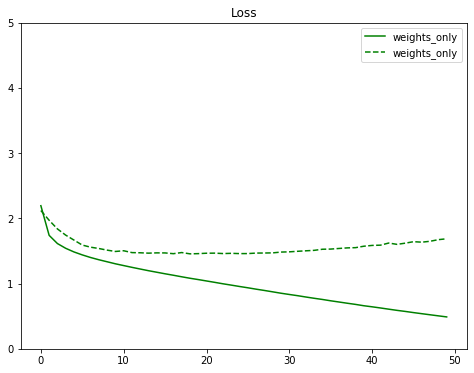

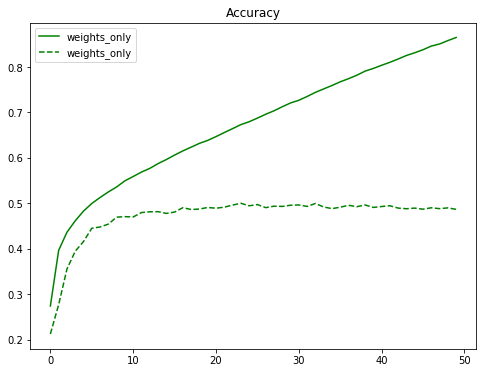

In [13]:
# Restart and Load back
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train
x_test, y_test = test

## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y   

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

model2.load_weights("./output/Day_086_weights.h5")
loss_loadback, acc_loadback = model2.evaluate(x_test, y_test)

print(loss_loadback, acc_loadback)

10000/10000 [==============================] - 1s 134us/step
1.6864612102508545 0.48660001158714294


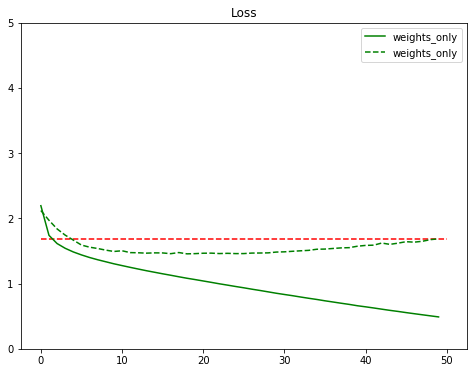

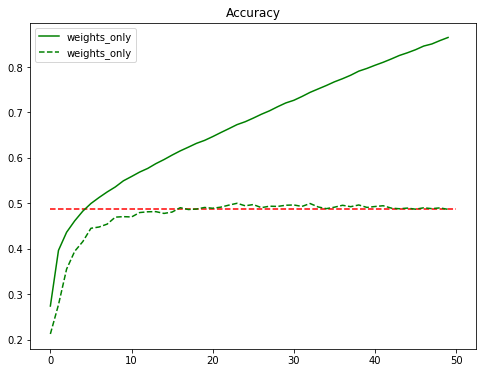

In [15]:
results = {}
results["weights_only"] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc,
                         'loss_loadback': loss_loadback,
                         'acc_loadback': acc_loadback}

import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["g", "b", "c", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['loss_loadback'], xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['acc_loadback'], xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.legend()
plt.show()